### Hackathon 1.0


##### Setting up the Environment


In [79]:
import pandas as pd
import numpy as np
import os
from termcolor import colored
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,train_test_split
from catboost import CatBoostClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

In [80]:
os.getcwd()

'c:\\Users\\Aditya.mathur\\Documents\\Workspace\\Python\\TSC-Hackathon'

#### Reading the data and performing EDA: 

Raw Data Source: Train.csv


In [81]:
raw_df = pd.read_csv('Data/Train.csv')

In [82]:
#Checking the dataset head and Shape of the raw data
print(f"data sample \n \n: {raw_df.head()}")
print(f"Shape of the data is {raw_df.shape}")

data sample 
 
:            ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_0040R73        2010-05-14      2011-05-13    Male   30   
1  ID_0046BNK        2010-11-29      2011-11-28  Female   79   
2  ID_005QMC3        2010-03-21      2011-03-20    Male   43   
3  ID_0079OHW        2010-08-21      2011-08-20    Male    2   
4  ID_00BRP63        2010-08-29      2010-12-31  Entity   20   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-05-14       1       Saloon              Black   
1             2010-11-29       1         JEEP               Grey   
2             2010-03-21       1       Saloon                Red   
3             2010-08-21       1          NaN                NaN   
4             2010-08-29       3          NaN                NaN   

  Subject_Car_Make LGA_Name  State  ProductName  target  
0           TOYOTA      NaN    NaN  Car Classic       0  
1           TOYOTA      NaN    NaN  Car Classic       1  
2           TOY

Observations:
- The Taget column is either 0 or 1 ; 
- Most of the features in the dataset are categorical ;
- Age , Number of Policies and Target are numeric

as per the observations Target should not be a Numeric column

In [83]:
# percentile list
perc =[.20, .40, .60, .80]
  
# list of dtypes to include
include =['object', 'float', 'int']

raw_df.describe(percentiles = perc, include = include).T

,count,unique,top,freq,mean,std,min,20%,40%,50%,60%,80%,max
ID,12079,12079,ID_0040R73,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Policy Start Date,12079,376,2010-03-27,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Policy End Date,12079,372,2010-12-31,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,11720,7,Male,7617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,12079.0,NaN,NaN,NaN,42.234539,97.492565,-6099.0,33.0,39.0,41.0,43.0,52.0,320.0
First Transaction Date,12079,376,2010-03-27,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
No_Pol,12079.0,NaN,NaN,NaN,1.307227,0.733085,1.0,1.0,1.0,1.0,1.0,2.0,10.0
Car_Category,8341,16,Saloon,6034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subject_Car_Colour,5117,45,Black,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subject_Car_Make,9603,74,TOYOTA,4975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
raw_df.info(verbose = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


As per the initial look upon the data we can see that we recieved 12079 loan applications and we have 13 columns to have profiling of the applicant.
    

Data Quality Checks:
- Checking % Missing Values - Incompleteness of the Data
- Checking the Data Quality and Outliers

In [85]:
def df_null_percentage(df = None):
    train_missing = (1 - df.count()/len(df)) * 100
    return train_missing.sort_values(ascending = False)


In [86]:
print(f"In the Raw Datasetm we could see the Nulls in the Rows as:\n\n {df_null_percentage(raw_df)}")

In the Raw Datasetm we could see the Nulls in the Rows as:

 Subject_Car_Colour        57.637222
State                     53.713056
LGA_Name                  53.613710
Car_Category              30.946270
Subject_Car_Make          20.498386
Gender                     2.972100
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
target                     0.000000
dtype: float64


Columns: Subject_Car_Colour, State ,LGA_Name are the columns with most amount of information missing,  more than 50%, we will remove them from the analysis.

Cleaning Data: Step 1: Removing Columns where more than 50 % values are NULL

In [87]:
insurance_application_df= raw_df[raw_df.columns[raw_df.isnull().sum() < len(raw_df)/2]]
print(f"Shape of the data after removing the features, having > 50 % NULLS \n: {insurance_application_df.shape}")

Shape of the data after removing the features, having > 50 % NULLS 
: (12079, 11)


In [88]:
print(f"Info on the Loan_application Data: {insurance_application_df.info()}")
insurance_application_df.describe(percentiles = perc, include = include).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Make        9603 non-null   object
 9   ProductName             12079 non-null  object
 10  target                  12079 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 1.0+ MB
Info on the Loan_application Data: None


,count,unique,top,freq,mean,std,min,20%,40%,50%,60%,80%,max
ID,12079,12079,ID_0040R73,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Policy Start Date,12079,376,2010-03-27,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Policy End Date,12079,372,2010-12-31,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,11720,7,Male,7617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,12079.0,NaN,NaN,NaN,42.234539,97.492565,-6099.0,33.0,39.0,41.0,43.0,52.0,320.0
First Transaction Date,12079,376,2010-03-27,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
No_Pol,12079.0,NaN,NaN,NaN,1.307227,0.733085,1.0,1.0,1.0,1.0,1.0,2.0,10.0
Car_Category,8341,16,Saloon,6034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subject_Car_Make,9603,74,TOYOTA,4975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductName,12079,9,Car Classic,6485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observations:
- ID is a unique Identifier in the dataset
- There are 7 Distinct values for Gender which we should take a look into 
- The minimum value for Age is a negative number, hence we need to check for the Age column's sanity
- Date Columns like: Policy Start Date, Policy End Date, First Transaction Date are strings which should be of date format

In [89]:
#Date Conversion:
def date_format_conversion(df = None):
    date_cols = [col for col in df.columns if 'Date' in col]
    for col in df.columns:
        if col in date_cols:
            df[col] = pd.to_datetime(df[col])
    return df


    
insurance_application_df = date_format_conversion(insurance_application_df)


In [90]:
insurance_application_df.Age.unique()

array([   30,    79,    43,     2,    20,    37,    40,    71,    58,
          45,    51,   120,    38,    81,    69,    31,    70,    34,
           1,    41,    47,    36,    46,    48,    39,    63,    42,
          27,    64,    50,    53,    33,    23,    32,    59,    60,
          52,    54,    44,    11,    78,    28,    29,    57,    12,
          65,    35,    73,    56,    55,    26,    49,    18,    14,
          62,    25,    61,    72,    82,    67,     7,    10,    68,
          21,    76,    24,    66,     3,    93,    22,    77,    19,
          80,     9,     6,   -76,    -2,    89,    74,    75,    84,
          16,    90,   140,     8,     5,    13,    86,    15,   320,
         -12,    83,    85, -6099, -5939,     4,   -22,   144,   112,
          17,     0,    88,   -27,    87,   133,   102,   -51,   128,
         -26,   100], dtype=int64)

##### we know the ages cannot be negative numbers, hence need a stratergy to replace the negative numbers there
Strategy:
- if the age is negative and between 18 and 100, we will take the absolute value
- if age > 100  then it is sketchy, so need to make it NA
- if age is < 18, need to make it NA.

Reasoning to keep the age between 18 and 100 is that the leagal age for driving or getting a driver's licence is 18 years in Nigeria (ref: https://en.wikipedia.org/wiki/List_of_minimum_driving_ages)

Once we have the ages corrected, we can replace the NA values in age with a central value like mean.

In [91]:
def valid_age(age:int):
    if age < 0:
        if abs(age) >= 18 and abs(age) < 100:
            return int(abs(age))
    elif age < 18:
        return np.nan
    elif age > 100:
        return np.nan
    else:
        return int(age)

# Cleaning the Age extreme values
insurance_application_df.Age = insurance_application_df.Age.map(lambda x: valid_age(x))



In [92]:
df_null_percentage(insurance_application_df)

Car_Category              30.946270
Subject_Car_Make          20.498386
Age                        7.649640
Gender                     2.972100
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
target                     0.000000
dtype: float64

In [93]:
insurance_application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      12079 non-null  object        
 1   Policy Start Date       12079 non-null  datetime64[ns]
 2   Policy End Date         12079 non-null  datetime64[ns]
 3   Gender                  11720 non-null  object        
 4   Age                     11155 non-null  float64       
 5   First Transaction Date  12079 non-null  datetime64[ns]
 6   No_Pol                  12079 non-null  int64         
 7   Car_Category            8341 non-null   object        
 8   Subject_Car_Make        9603 non-null   object        
 9   ProductName             12079 non-null  object        
 10  target                  12079 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(5)
memory usage: 1.0+ MB


In [94]:
numerical_features = list(insurance_application_df.select_dtypes(['int64','float64']).nunique().index)

In [95]:
# Substituting NAs with Central value - Mean
# Replacing all the numeric volumns where we have Nulls with the mean of the columns to :

for column in numerical_features:

    insurance_application_df[column].fillna(round(insurance_application_df[column].mean()), inplace=True)





In [96]:
#Converting Age to int
insurance_application_df['Age'] = insurance_application_df['Age'].map(np.int64)


In [97]:
insurance_application_df.describe(include = 'int')


,Age,No_Pol,target
count,12079.00000,12079.000000,12079.000000
mean,42.93170,1.307227,0.120457
std,11.33885,0.733085,0.325509
min,18.00000,1.000000,0.000000
25%,36.00000,1.000000,0.000000
50%,42.00000,1.000000,0.000000
75%,49.00000,1.000000,0.000000
max,100.00000,10.000000,1.000000


In [98]:
df_null_percentage(insurance_application_df)

Car_Category              30.946270
Subject_Car_Make          20.498386
Gender                     2.972100
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
target                     0.000000
dtype: float64

Distinct Genders in the dataset:
 ['Male' 'Female' 'Entity' 'Joint Gender' nan 'NO GENDER' 'NOT STATED'
 'SEX']


<AxesSubplot:>

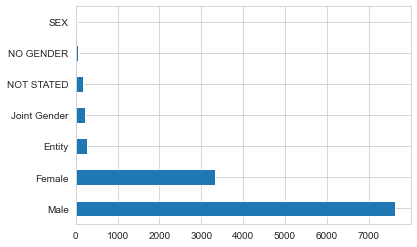

In [99]:
# Treating the values for gender
print(f"Distinct Genders in the dataset:\n {insurance_application_df.Gender.unique()}")

# Checking the distribution of gender:
insurance_application_df['Gender'].value_counts(ascending = False).plot.barh()

Since the Genders other than "Male" and "Female" are very sparse in the distribution of the dataset.
we will map those values to "others"
 

In [100]:
def gender_map(gender:object):

    if type(gender) != str:
        return 'other'
    else:
        if gender.lower() == 'male':
            return 'male'
        elif gender.lower() == 'female':
            return 'female'
        else:
            return 'other'



In [101]:
insurance_application_df.Gender= insurance_application_df.Gender.map(lambda x: gender_map(x))

<AxesSubplot:>

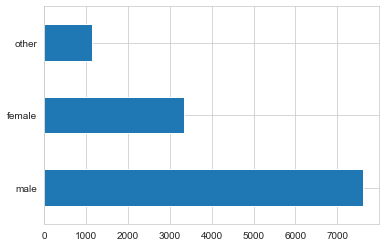

In [102]:
# Checking the distribution of gender:
insurance_application_df['Gender'].value_counts(ascending = False).plot.barh()

In [103]:
df_null_percentage(insurance_application_df)

Car_Category              30.946270
Subject_Car_Make          20.498386
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Gender                     0.000000
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
target                     0.000000
dtype: float64

Car Category and Subject Car Make are categorical variables checking for the distribution of these features

<AxesSubplot:>

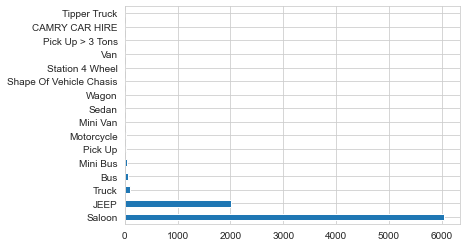

In [104]:
insurance_application_df['Car_Category'].value_counts(ascending = False).plot.barh()

<AxesSubplot:>

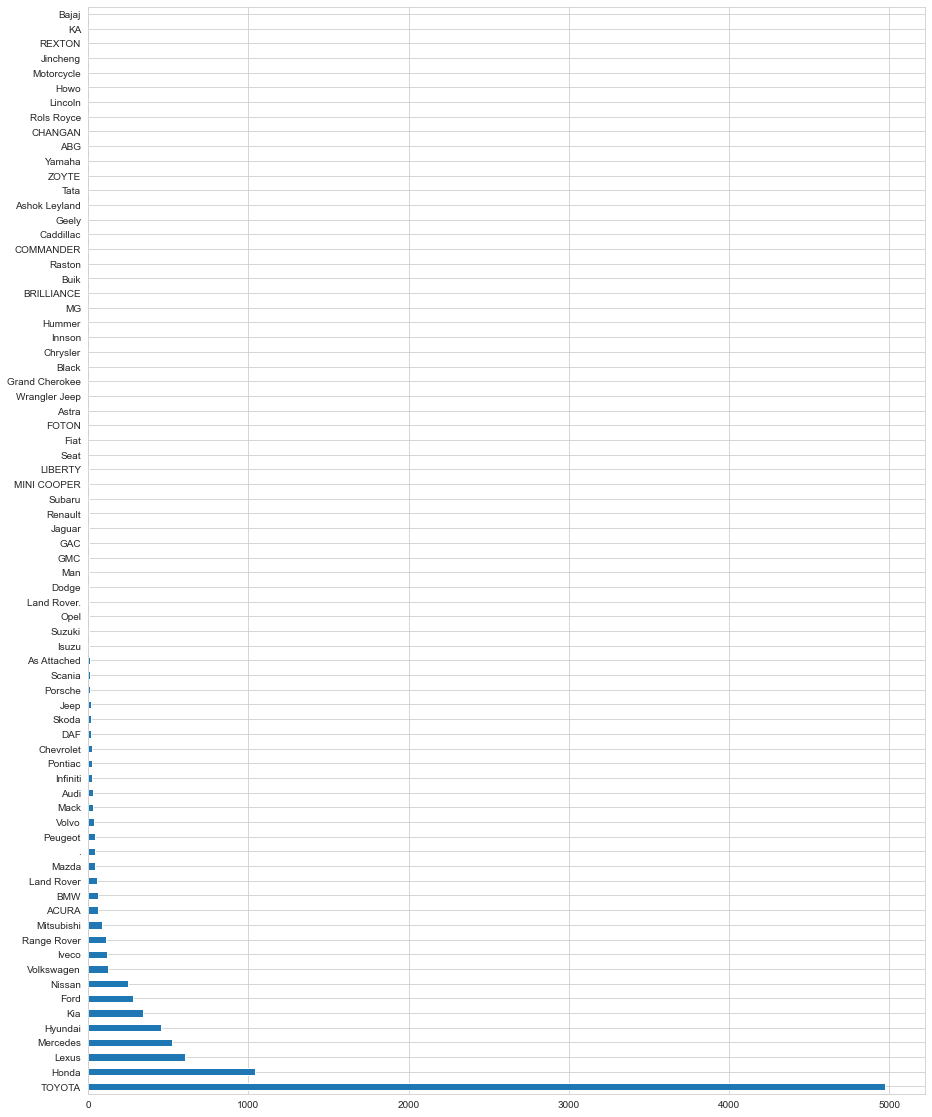

In [105]:
plt.figure(figsize=[15,20])
insurance_application_df['Subject_Car_Make'].value_counts(ascending = False).plot.barh()

We can safely replace the missing values with the mode (Central Value)  of the data for the features:
- 'Car_Category'
- 'Subject_Car_Make'


In [106]:
insurance_application_df['Subject_Car_Make'].fillna(insurance_application_df['Subject_Car_Make'].mode()[0],inplace = True)
insurance_application_df['Car_Category'].fillna(insurance_application_df['Car_Category'].mode()[0],inplace = True)

<AxesSubplot:>

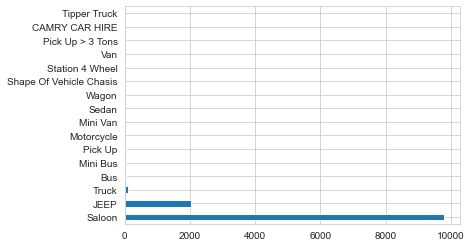

In [107]:
insurance_application_df['Car_Category'].value_counts(ascending = False).plot.barh()

<AxesSubplot:>

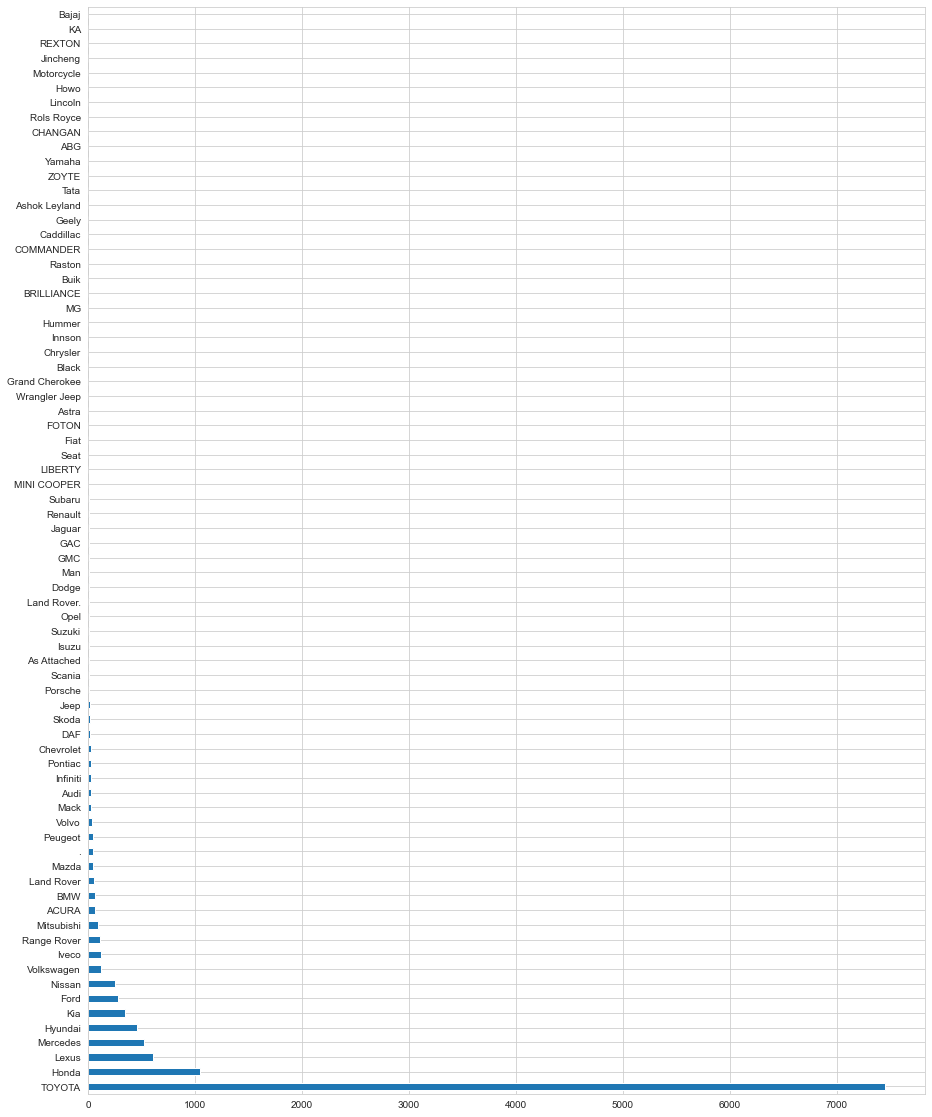

In [108]:
plt.figure(figsize=[15,20])
insurance_application_df['Subject_Car_Make'].value_counts(ascending = False).plot.barh()

In [109]:
df_null_percentage(insurance_application_df)

ID                        0.0
Policy Start Date         0.0
Policy End Date           0.0
Gender                    0.0
Age                       0.0
First Transaction Date    0.0
No_Pol                    0.0
Car_Category              0.0
Subject_Car_Make          0.0
ProductName               0.0
target                    0.0
dtype: float64

In [110]:
insurance_application_df.shape


(12079, 11)

After the clean up we have 12079 rows and 11 features.

## EDA
 - Checking for Class Imbalances
 

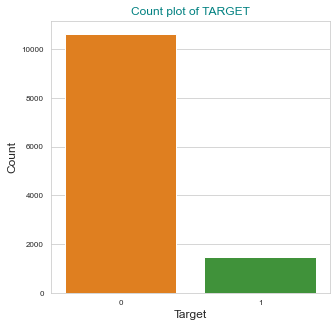

In [111]:
sns.set_style("whitegrid")
plt.figure(figsize=[5,5])
sns.countplot(insurance_application_df.target, palette= 'Paired_r')
plt.title('Count plot of TARGET', fontdict= {'fontsize': 12, 'color': 'Teal'})
plt.xlabel('Target', fontsize= 12)
plt.xticks(fontsize= 8)
plt.ylabel('Count', fontsize= 12)
plt.yticks(fontsize= 8)
plt.show()


Observations:
- we can see that the target column has clear imbalance in the favour of value '0'

Univariate Analysis:

- To Check if there are any outliers in the DataFrame
- Further treatment of data based on inferences

In [112]:
categorical_columns = list(insurance_application_df.describe(include = "O").columns)

In [113]:
print(f"Categorical Columns:\t {categorical_columns} ")
categorical_columns.pop(0) # Since Plotting ID will not make sense

Categorical Columns:	 ['ID', 'Gender', 'Car_Category', 'Subject_Car_Make', 'ProductName'] 


'ID'

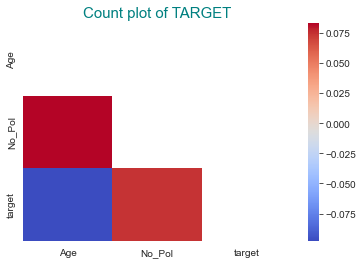

In [114]:
#Checking the correlation among varibles
sns.set_style("whitegrid")
sns.heatmap(insurance_application_df.corr(), cmap = "coolwarm",mask= np.triu(insurance_application_df.corr()))
plt.title('Count plot of TARGET', fontdict= {'fontsize': 15, 'color': 'Teal'})

plt.show()




In [115]:
insurance_application_df.corr()

,Age,No_Pol,target
Age,1.000000,0.082826,-0.097527
No_Pol,0.082826,1.000000,0.074245
target,-0.097527,0.074245,1.000000


We donot see any correlations between Age, or Number of Policies with target

In [116]:
print(f'Percentage of Observations in Data available after data cleaning:  {round((len(insurance_application_df.index)/12079)*100,2)} %')

Percentage of Observations in Data available after data cleaning:  100.0 %


Not loosing any data points, however, we have eleminated features which are more than 50% NULLS


In [117]:
insurance_application_df.describe(percentiles = perc, include = include).T

,count,unique,top,freq,mean,std,min,20%,40%,50%,60%,80%,max
ID,12079,12079,ID_0040R73,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,12079,3,male,7617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,12079.0,NaN,NaN,NaN,42.9317,11.33885,18.0,34.0,40.0,42.0,43.0,50.0,100.0
No_Pol,12079.0,NaN,NaN,NaN,1.307227,0.733085,1.0,1.0,1.0,1.0,1.0,2.0,10.0
Car_Category,12079,16,Saloon,9772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subject_Car_Make,12079,74,TOYOTA,7451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductName,12079,9,Car Classic,6485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,12079.0,NaN,NaN,NaN,0.120457,0.325509,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modelling

In [118]:
dummy = pd.get_dummies(insurance_application_df[categorical_columns], drop_first = True)

In [119]:
insurance_application_df = pd.concat([insurance_application_df, dummy], axis=1)

In [120]:
insurance_application_df.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Make,ProductName,...,Subject_Car_Make_Yamaha,Subject_Car_Make_ZOYTE,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,male,30,2010-05-14,1,Saloon,TOYOTA,Car Classic,...,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,female,79,2010-11-29,1,JEEP,TOYOTA,Car Classic,...,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,male,43,2010-03-21,1,Saloon,TOYOTA,Car Classic,...,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,male,43,2010-08-21,1,Saloon,TOYOTA,CarSafe,...,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,other,20,2010-08-29,3,Saloon,TOYOTA,Muuve,...,0,0,0,0,0,0,0,0,0,1


In [121]:
# Dropping redundant columns
insurance_application_df.drop(categorical_columns, 1, inplace = True)

In [122]:
print(insurance_application_df.shape)

print(insurance_application_df.columns)

(12079, 105)
Index(['ID', 'Policy Start Date', 'Policy End Date', 'Age',
       'First Transaction Date', 'No_Pol', 'target', 'Gender_male',
       'Gender_other', 'Car_Category_CAMRY CAR HIRE',
       ...
       'Subject_Car_Make_Yamaha', 'Subject_Car_Make_ZOYTE',
       'ProductName_Car Classic', 'ProductName_Car Plus',
       'ProductName_Car Vintage', 'ProductName_CarFlex', 'ProductName_CarSafe',
       'ProductName_Customized Motor', 'ProductName_Motor Cycle',
       'ProductName_Muuve'],
      dtype='object', length=105)


<AxesSubplot:>

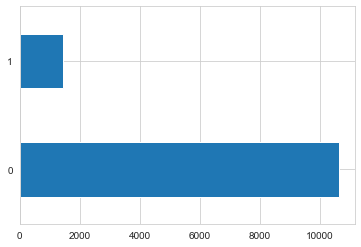

In [123]:
insurance_application_df.target.value_counts().plot.barh()

In [124]:
# Random Under and Over Sampling:
class_count_0, class_count_1 = insurance_application_df['target'].value_counts()

In [125]:
# Separate class
class_0 = insurance_application_df[insurance_application_df['target'] == 0]
class_1 = insurance_application_df[insurance_application_df['target'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (10624, 105)
class 1: (1455, 105)


total class of 1 and0: 0    1455
1    1455
Name: target, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

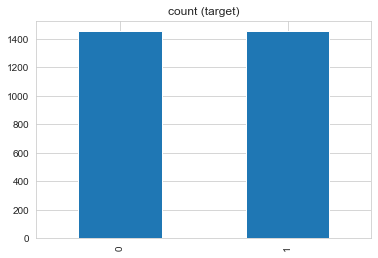

In [126]:
# Random Under sampling:
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:",test_under['target'].value_counts())# plot the count after under-sampeling
test_under['target'].value_counts().plot(kind='bar', title='count (target)')

In [127]:
test_under.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Gender_male,Gender_other,Car_Category_CAMRY CAR HIRE,...,Subject_Car_Make_Yamaha,Subject_Car_Make_ZOYTE,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
11550,ID_YICH85T,2010-12-23,2011-12-22,43,2010-12-23,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8446,ID_PE67JL5,2010-11-08,2011-10-02,41,2010-11-08,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3963,ID_BU6J1WF,2010-08-26,2011-08-25,47,2010-08-26,2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5134,ID_FGB24TU,2010-09-03,2011-09-02,53,2010-09-03,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5217,ID_FQKZ9XI,2010-10-29,2011-01-28,43,2010-10-29,2,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [128]:
from sklearn.model_selection import train_test_split

#X = insurance_application_df.drop(['target'], 1)
X =test_under.drop(['target'], 1)

# Putting the target variable in y
#y = insurance_application_df['target']
y = test_under['target']

In [129]:
# Since the ID is just an Identifier, we will remove it from the analysis
X = X.drop(['ID'],1)

In [130]:
date_cols = [col for col in insurance_application_df.columns if 'Date' in col]

In [131]:
# Removing Date columns as we donot need them for training the model.
X.drop(date_cols,1,inplace = True)

In [132]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10)

#### Feature Scaling
it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale.

we will opt for MinMax Scaler in our analysis

In [133]:
X_train.columns

Index(['Age', 'No_Pol', 'Gender_male', 'Gender_other',
       'Car_Category_CAMRY CAR HIRE', 'Car_Category_JEEP',
       'Car_Category_Mini Bus', 'Car_Category_Mini Van',
       'Car_Category_Motorcycle', 'Car_Category_Pick Up',
       'Car_Category_Pick Up > 3 Tons', 'Car_Category_Saloon',
       'Car_Category_Sedan', 'Car_Category_Shape Of Vehicle Chasis',
       'Car_Category_Station 4 Wheel', 'Car_Category_Tipper Truck',
       'Car_Category_Truck', 'Car_Category_Van', 'Car_Category_Wagon',
       'Subject_Car_Make_ABG', 'Subject_Car_Make_ACURA',
       'Subject_Car_Make_As Attached', 'Subject_Car_Make_Ashok Leyland',
       'Subject_Car_Make_Astra', 'Subject_Car_Make_Audi',
       'Subject_Car_Make_BMW', 'Subject_Car_Make_BRILLIANCE',
       'Subject_Car_Make_Bajaj', 'Subject_Car_Make_Black',
       'Subject_Car_Make_Buik', 'Subject_Car_Make_CHANGAN',
       'Subject_Car_Make_COMMANDER', 'Subject_Car_Make_Caddillac',
       'Subject_Car_Make_Chevrolet', 'Subject_Car_Make_Chrysler'

In [134]:
numerical_features.pop() # Removing the "target" column from numerical features


'target'

In [135]:
X_train[numerical_features]

,Age,No_Pol
129,30,2
2241,36,1
321,35,1
5152,39,1
3981,34,1
...,...,...
6249,34,1
4613,32,1
7823,45,3
4979,35,1


In [136]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

X_train.head()

,Age,No_Pol,Gender_male,Gender_other,Car_Category_CAMRY CAR HIRE,Car_Category_JEEP,Car_Category_Mini Bus,Car_Category_Mini Van,Car_Category_Motorcycle,Car_Category_Pick Up,...,Subject_Car_Make_Yamaha,Subject_Car_Make_ZOYTE,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
129,0.184615,0.2,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2241,0.276923,0.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
321,0.261538,0.0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5152,0.323077,0.0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3981,0.246154,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Looking at the correlations:

In [137]:
def highly_correlated_columns(df_train, threshold = 0.80):
    cor_matrix = df_train.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    if len(to_drop) > 0:
        return(to_drop)
    else:
        return("No Correlated Columns")






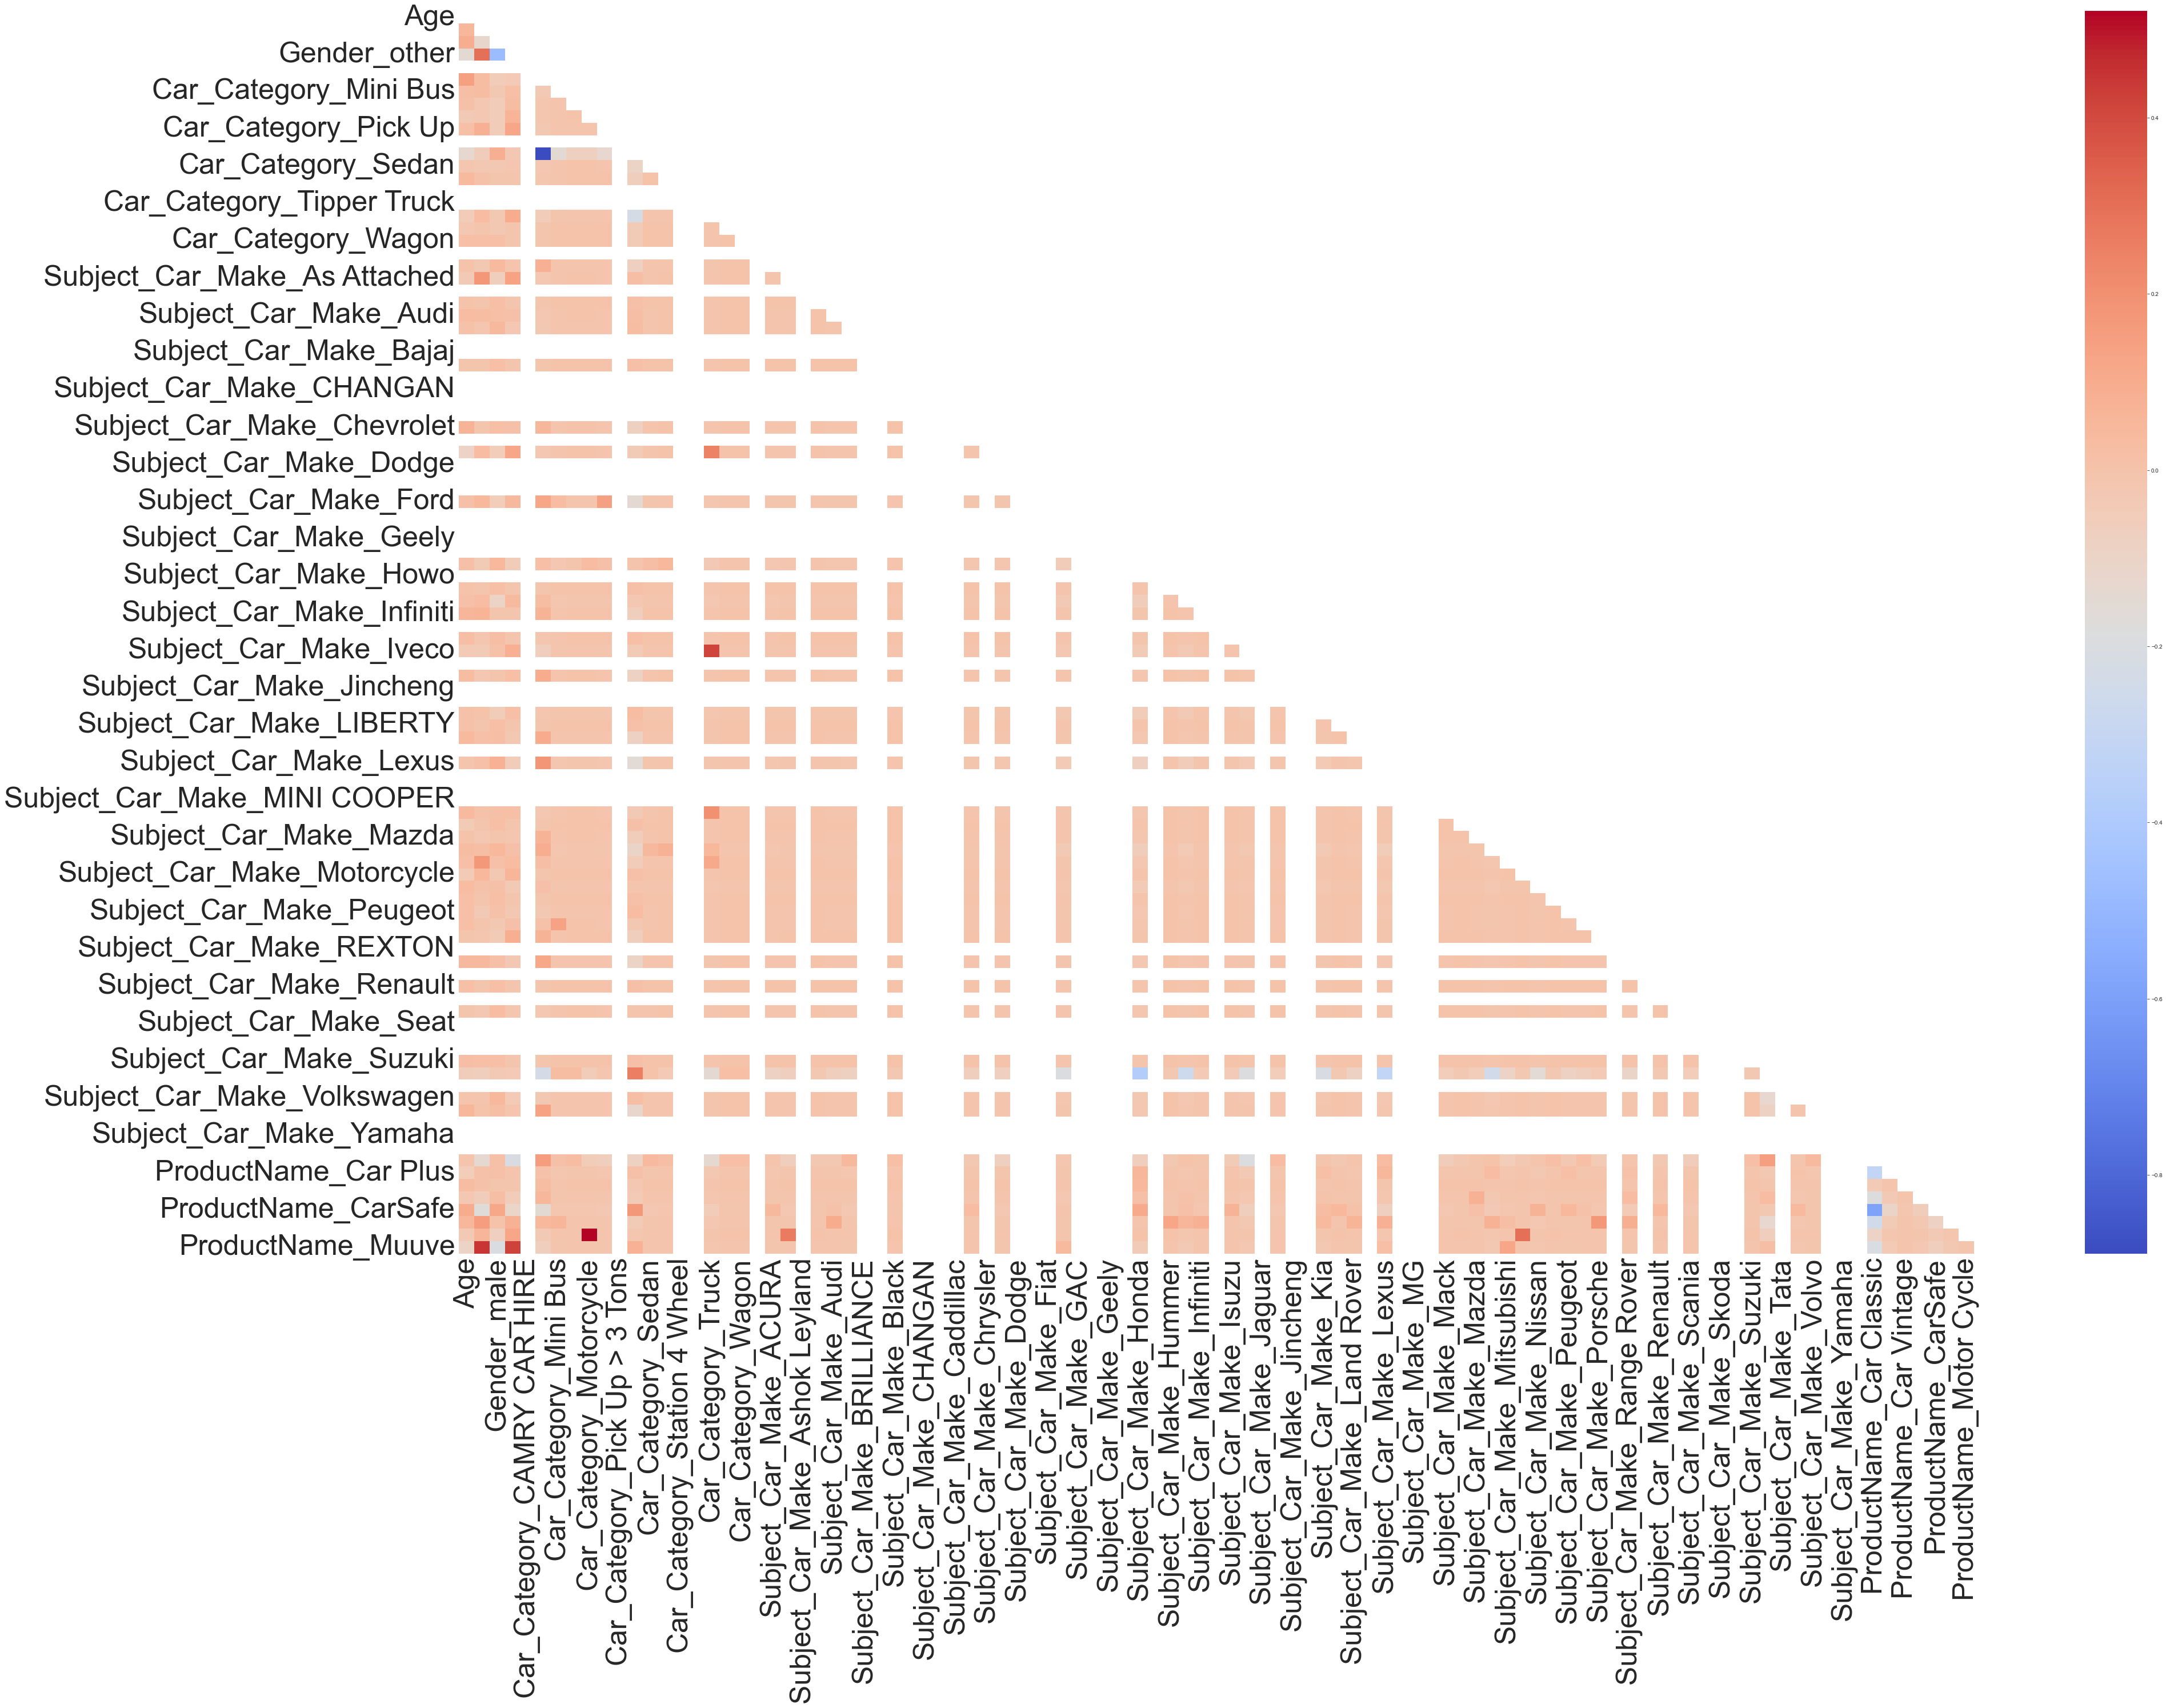

In [138]:
# Let's see the correlation matrix 
plt.figure(figsize = (60,40))        # Size of the figure
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
sns.heatmap(X_train.corr(), cmap = "coolwarm",mask= np.triu(X_train.corr()))
plt.show()

In [139]:
to_drop = highly_correlated_columns(X_train)
print(f'Correlated Columns which can be dropped: \n{to_drop}')



Correlated Columns which can be dropped: 
['Car_Category_Saloon']


We Do see that the Car_Category_Saloon is highly coorelated to Car_Categroy_JEEP. In order to not induce multicolinerarity in our model, we will drop column 'Car_Category_Saloon' from the analysis.


In [140]:
X_train.drop(to_drop, inplace = True, axis = 1)

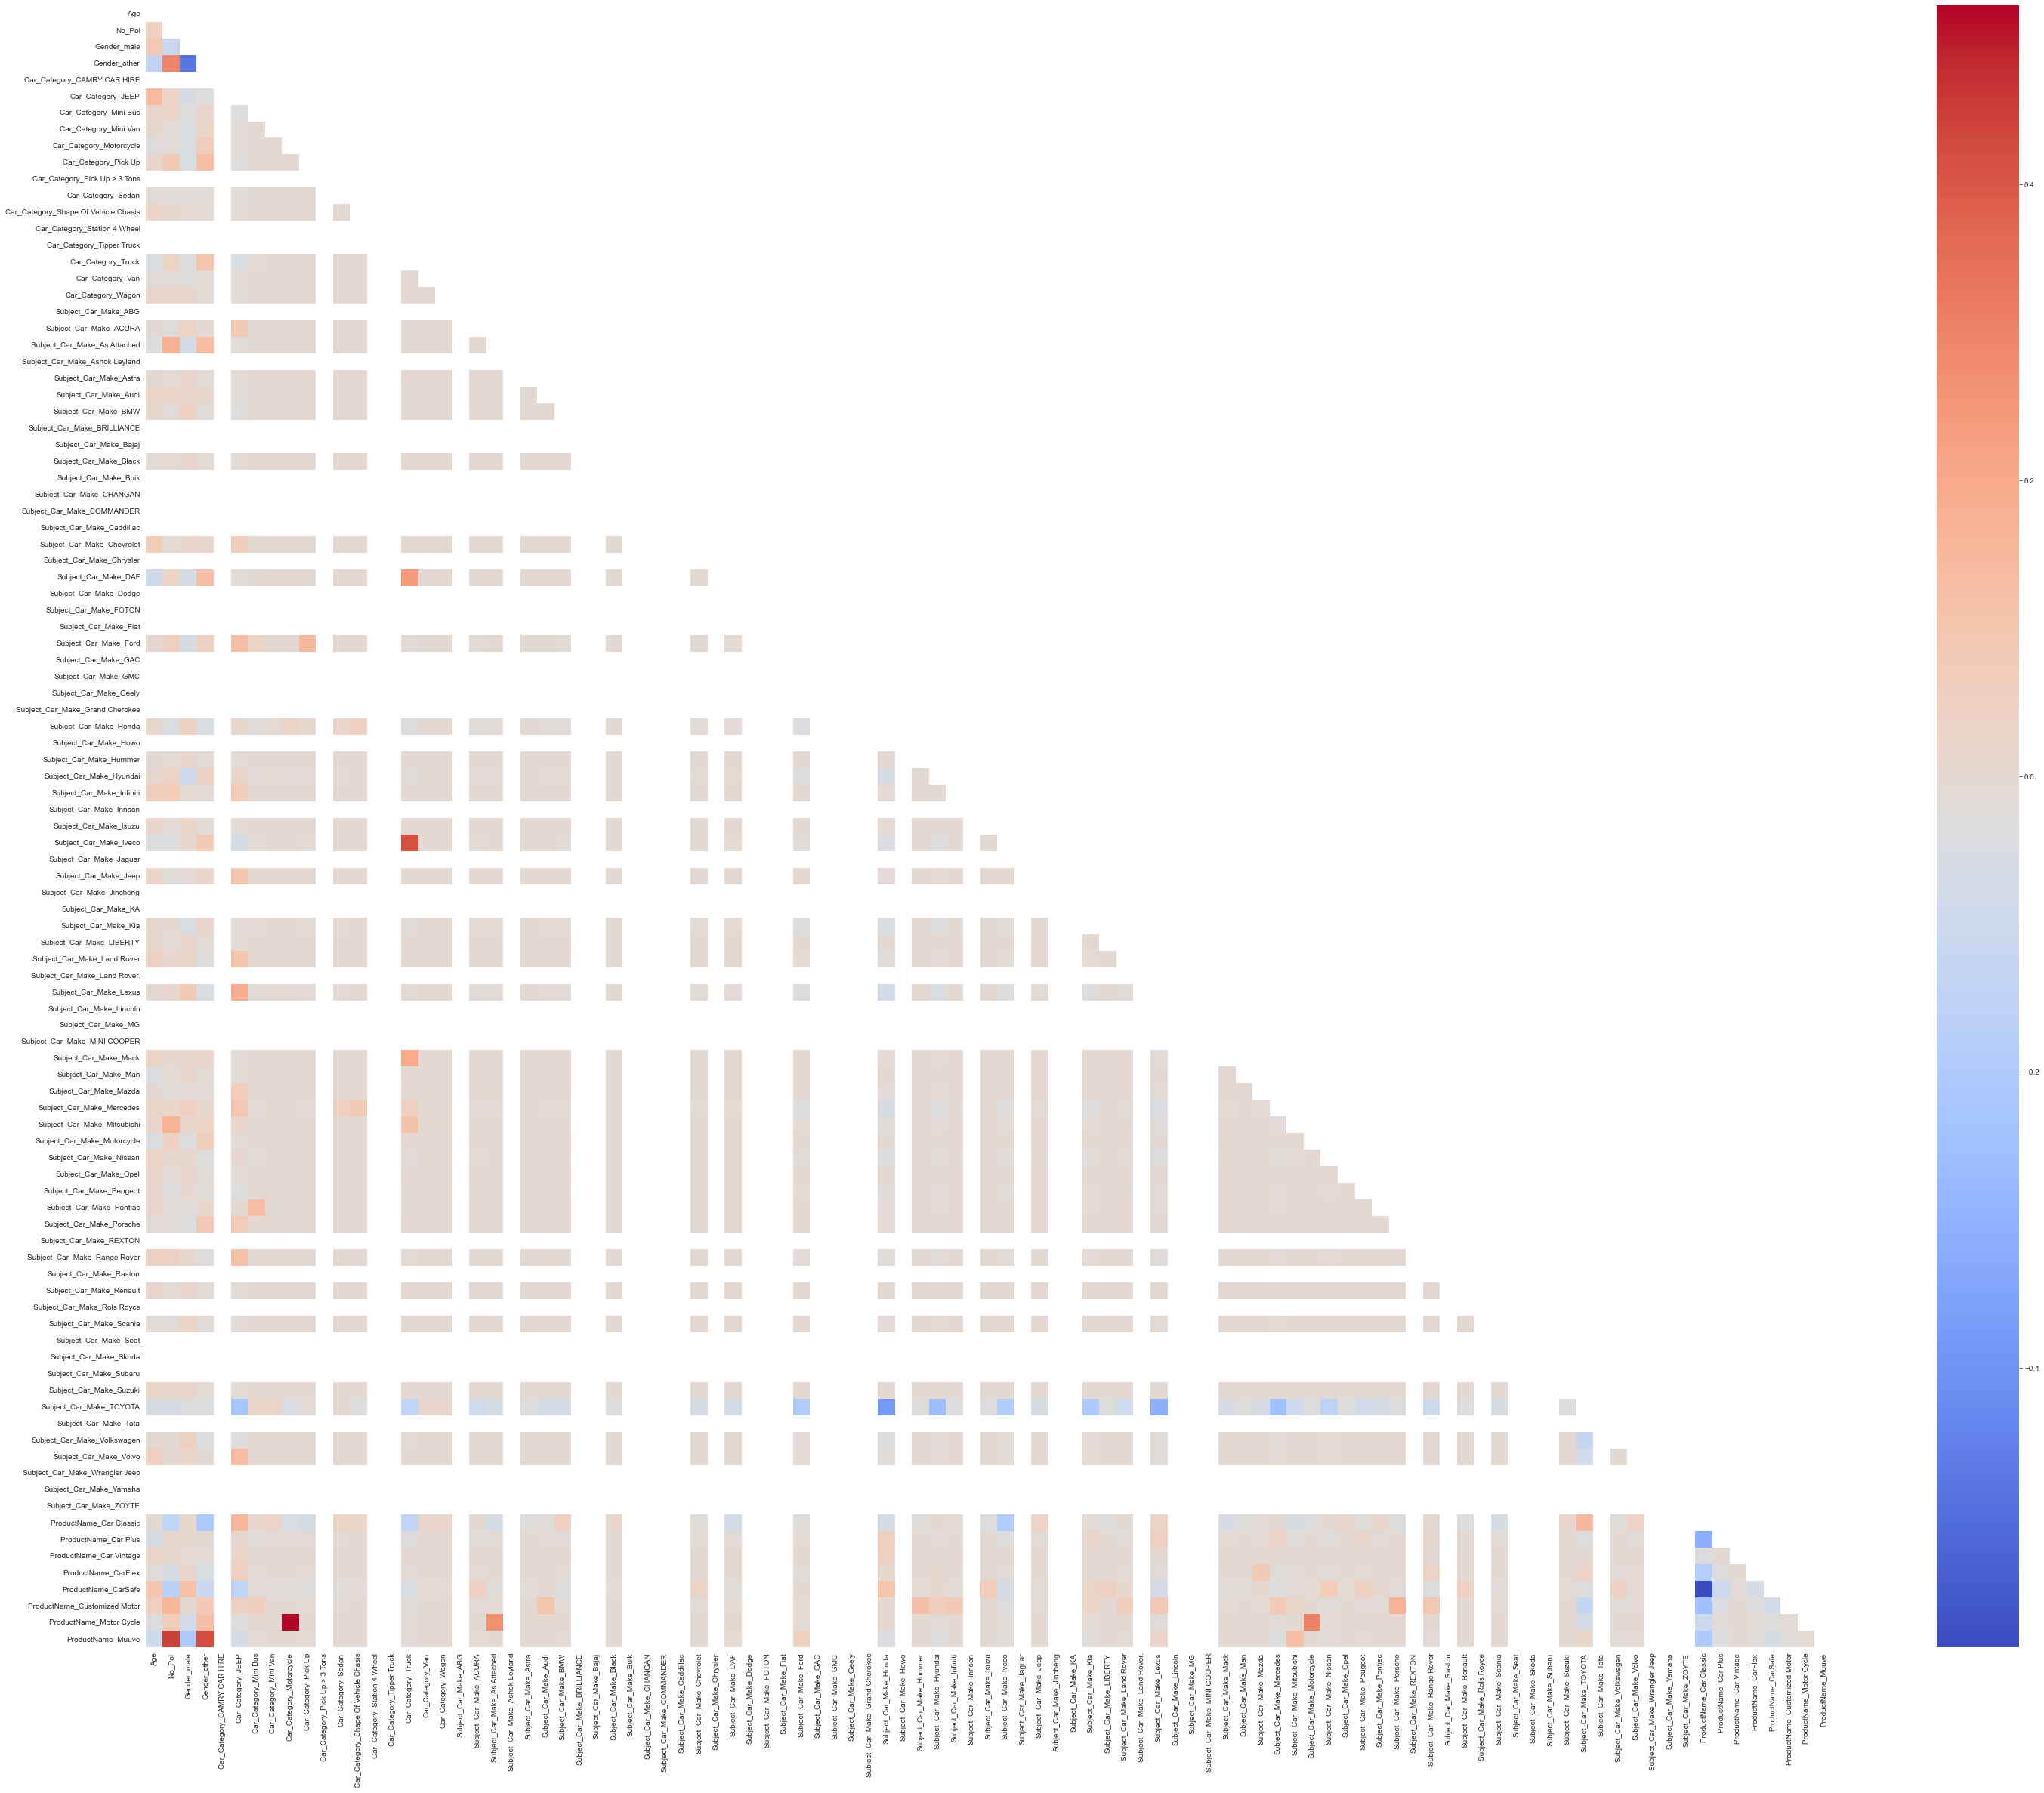

In [141]:
# Let's see the correlation matrix 
plt.figure(figsize = (50,40))        # Size of the figure
sns.heatmap(X_train.corr(), cmap = "coolwarm",mask= np.triu(X_train.corr()))
plt.show()

In [142]:
to_drop = highly_correlated_columns(X_train)
print(f'Correlated Columns which can be dropped: \n{to_drop}')

Correlated Columns which can be dropped: 
No Correlated Columns


In [143]:
print(f'The Shape of Training Data is : {X_train.shape}')

The Shape of Training Data is : (2036, 99)


### Feature Selection:


In [144]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [145]:
logreg = LogisticRegression()


In [147]:
X_train.head()

,Age,No_Pol,Gender_male,Gender_other,Car_Category_CAMRY CAR HIRE,Car_Category_JEEP,Car_Category_Mini Bus,Car_Category_Mini Van,Car_Category_Motorcycle,Car_Category_Pick Up,...,Subject_Car_Make_Yamaha,Subject_Car_Make_ZOYTE,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
129,0.184615,0.2,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2241,0.276923,0.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
321,0.261538,0.0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5152,0.323077,0.0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3981,0.246154,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [148]:
# Creating a RFE object

# setting the limit of our feature variables to 12 (around ~20% of avaialble variables)
rfe = RFE(estimator = logreg,n_features_to_select = 12) 
rfe = rfe.fit(X_train, y_train) #fitting the object on our train dataset

In [149]:
rfe.support_

array([ True,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True,  True, False,  True])

In [150]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Age', True, 1),
 ('No_Pol', True, 1),
 ('Gender_male', False, 37),
 ('Gender_other', False, 36),
 ('Car_Category_CAMRY CAR HIRE', False, 54),
 ('Car_Category_JEEP', False, 49),
 ('Car_Category_Mini Bus', False, 15),
 ('Car_Category_Mini Van', False, 33),
 ('Car_Category_Motorcycle', False, 8),
 ('Car_Category_Pick Up', True, 1),
 ('Car_Category_Pick Up > 3 Tons', False, 65),
 ('Car_Category_Sedan', False, 9),
 ('Car_Category_Shape Of Vehicle Chasis', False, 43),
 ('Car_Category_Station 4 Wheel', False, 69),
 ('Car_Category_Tipper Truck', False, 50),
 ('Car_Category_Truck', False, 13),
 ('Car_Category_Van', False, 21),
 ('Car_Category_Wagon', False, 10),
 ('Subject_Car_Make_ABG', False, 78),
 ('Subject_Car_Make_ACURA', False, 38),
 ('Subject_Car_Make_As Attached', True, 1),
 ('Subject_Car_Make_Ashok Leyland', False, 86),
 ('Subject_Car_Make_Astra', False, 11),
 ('Subject_Car_Make_Audi', False, 45),
 ('Subject_Car_Make_BMW', True, 1),
 ('Subject_Car_Make_BRILLIANCE', False, 66),
 ('Su

In [151]:
col = list(X_train.columns[rfe.support_]) # These are the variables which will be used for further modelling
print(col)

['Age', 'No_Pol', 'Car_Category_Pick Up', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_BMW', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_Car Vintage', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


In [152]:
print(f'Columns Dropped from the analysis: \n {X_train.columns[~rfe.support_]}')

Columns Dropped from the analysis: 
 Index(['Gender_male', 'Gender_other', 'Car_Category_CAMRY CAR HIRE',
       'Car_Category_JEEP', 'Car_Category_Mini Bus', 'Car_Category_Mini Van',
       'Car_Category_Motorcycle', 'Car_Category_Pick Up > 3 Tons',
       'Car_Category_Sedan', 'Car_Category_Shape Of Vehicle Chasis',
       'Car_Category_Station 4 Wheel', 'Car_Category_Tipper Truck',
       'Car_Category_Truck', 'Car_Category_Van', 'Car_Category_Wagon',
       'Subject_Car_Make_ABG', 'Subject_Car_Make_ACURA',
       'Subject_Car_Make_Ashok Leyland', 'Subject_Car_Make_Astra',
       'Subject_Car_Make_Audi', 'Subject_Car_Make_BRILLIANCE',
       'Subject_Car_Make_Bajaj', 'Subject_Car_Make_Black',
       'Subject_Car_Make_Buik', 'Subject_Car_Make_CHANGAN',
       'Subject_Car_Make_COMMANDER', 'Subject_Car_Make_Caddillac',
       'Subject_Car_Make_Chevrolet', 'Subject_Car_Make_Chrysler',
       'Subject_Car_Make_DAF', 'Subject_Car_Make_Dodge',
       'Subject_Car_Make_FOTON', 'Subject_Car

In [153]:
# Calculate the VIFs for the new model
def vif_calculation(X_train_rfe):
    X_train_rfe = X_train_rfe.drop(['const'], axis=1) # Dropping constant variable from the df

    vif = pd.DataFrame()
    X = X_train_rfe
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)

    return vif 

Assessing the model with StatsModels : Model 1 ( logm1)

In [154]:
X_train_sm = sm.add_constant(X_train[col])
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 2036
Model:                            GLM   Df Residuals:                     2023
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1140.1
Date:                Sat, 16 Jul 2022   Deviance:                       2280.3
Time:                        18:14:07   Pearson chi2:                 2.02e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.2336
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7767      0.121      6.410      0.000       0.539       1.014
Age                             -1.2130      0.305     -3.977      0.000      -1.811      -0.615
No_Pol                           0.6600      0.383      1.725      0.085      -0.090       1.410
Car_Category_Pick Up             1.4839      1.074      1.381      0.167      -0.622       3.590
Subject_Car_Make_As Attached    21.6964   2.14e+04      0.001      0.999   -4.19e+04     4.2e+04
Subject_Car_Make_BMW            -1.2534      0.840     -1.493      0.135      -2.899       0.392
Subject_Car_Make_Iveco           1.2661      0.417      3.036      0.002       0.449       2.083
Subject_Car_Make_Peugeot         1.7208      1.039      1.656      0.098      -0.316       3.758
Subject_Car_Make_Volkswagen     -1.6749      0.660     -2.537      0.011      -2.969      -0.381
ProductName_Car Vintage        -22.8007   3.39e+04     -0.001      0.999   -6.64e+04    6.64e+04
ProductName_CarSafe             -3.7246      0.316    -11.802      0.000      -4.343      -3.106
ProductName_Customized Motor    -0.8919      0.262     -3.403      0.001      -1.406      -0.378
ProductName_Muuve                3.0117      1.028      2.928      0.003       0.996       5.027
================================================================================================
"""

From the p-values, we can see that we have variables with high p - values (>0.05) or variables which are not significant.

In [155]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
1,No_Pol,1.74
0,Age,1.58
11,ProductName_Muuve,1.33
9,ProductName_CarSafe,1.24
10,ProductName_Customized Motor,1.08
3,Subject_Car_Make_As Attached,1.05
2,Car_Category_Pick Up,1.02
5,Subject_Car_Make_Iveco,1.02
6,Subject_Car_Make_Peugeot,1.01
7,Subject_Car_Make_Volkswagen,1.01


The common heuristic we follow for the VIF values is:

Greater than 10: VIF value is definitely high, and the variable should be eliminated.
Greater than 5: Can be okay, but it is worth inspecting.
Less Than 5: Good VIF value. No need to eliminate this variable.
We will be dropping variables with high p-values and vif values one by one and check its impact on the model.

We will drop the column: Subject_Car_Make_As Attached Wheel, form the analysis since p-value is quite high and hence is not significant

In [157]:
col.remove('Subject_Car_Make_As Attached')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 11 
 ['Age', 'No_Pol', 'Car_Category_Pick Up', 'Subject_Car_Make_BMW', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_Car Vintage', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


In [158]:
#### Assessing the model with StatsModels : Model 2 ( logm2)

X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 2036
Model:                            GLM   Df Residuals:                     2024
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1141.9
Date:                Sat, 16 Jul 2022   Deviance:                       2283.7
Time:                        18:15:49   Pearson chi2:                 2.02e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.2323
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7821      0.121      6.460      0.000       0.545       1.019
Age                             -1.2371      0.304     -4.064      0.000      -1.834      -0.641
No_Pol                           0.7735      0.376      2.055      0.040       0.036       1.511
Car_Category_Pick Up             1.4589      1.075      1.358      0.175      -0.647       3.565
Subject_Car_Make_BMW            -1.2532      0.840     -1.493      0.136      -2.899       0.392
Subject_Car_Make_Iveco           1.2656      0.417      3.035      0.002       0.448       2.083
Subject_Car_Make_Peugeot         1.7247      1.040      1.658      0.097      -0.314       3.763
Subject_Car_Make_Volkswagen     -1.6845      0.661     -2.550      0.011      -2.980      -0.390
ProductName_Car Vintage        -20.8048   1.25e+04     -0.002      0.999   -2.45e+04    2.44e+04
ProductName_CarSafe             -3.7233      0.316    -11.798      0.000      -4.342      -3.105
ProductName_Customized Motor    -0.9104      0.262     -3.473      0.001      -1.424      -0.397
ProductName_Muuve                2.9542      1.028      2.874      0.004       0.940       4.969
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.52
16,ProductName_CarSafe,1.41
17,ProductName_Customized Motor,1.08
9,Subject_Car_Make_Mitsubishi,1.02
7,Subject_Car_Make_Iveco,1.01
8,Subject_Car_Make_Land Rover,1.01
11,Subject_Car_Make_Porsche,1.01
13,Subject_Car_Make_Volkswagen,1.01
18,ProductName_Muuve,1.01
4,Subject_Car_Make_As Attached,1.00


Next we can drop : ProductName_Car Vintage column

In [159]:
col.remove('ProductName_Car Vintage')

print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 10 
 ['Age', 'No_Pol', 'Car_Category_Pick Up', 'Subject_Car_Make_BMW', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 3 ( logm3)

In [160]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 2036
Model:                            GLM   Df Residuals:                     2025
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1143.5
Date:                Sat, 16 Jul 2022   Deviance:                       2287.0
Time:                        18:17:09   Pearson chi2:                 2.03e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2310
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7838      0.121      6.480      0.000       0.547       1.021
Age                             -1.2500      0.304     -4.112      0.000      -1.846      -0.654
No_Pol                           0.7714      0.376      2.050      0.040       0.034       1.509
Car_Category_Pick Up             1.4631      1.075      1.361      0.173      -0.643       3.570
Subject_Car_Make_BMW            -1.2500      0.840     -1.489      0.137      -2.896       0.396
Subject_Car_Make_Iveco           1.2684      0.417      3.041      0.002       0.451       2.086
Subject_Car_Make_Peugeot         1.7269      1.040      1.661      0.097      -0.311       3.765
Subject_Car_Make_Volkswagen     -1.6820      0.661     -2.546      0.011      -2.977      -0.387
ProductName_CarSafe             -3.7202      0.316    -11.789      0.000      -4.339      -3.102
ProductName_Customized Motor    -0.9064      0.262     -3.458      0.001      -1.420      -0.393
ProductName_Muuve                2.9571      1.028      2.877      0.004       0.943       4.972
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.51
15,ProductName_CarSafe,1.41
16,ProductName_Customized Motor,1.08
9,Subject_Car_Make_Mitsubishi,1.02
7,Subject_Car_Make_Iveco,1.01
8,Subject_Car_Make_Land Rover,1.01
11,Subject_Car_Make_Porsche,1.01
13,Subject_Car_Make_Volkswagen,1.01
17,ProductName_Muuve,1.01
4,Subject_Car_Make_As Attached,1.00


Next we can remove: Car_Category_Pick Up column

In [161]:
col.remove('Car_Category_Pick Up')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 9 
 ['Age', 'No_Pol', 'Subject_Car_Make_BMW', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 4 ( logm4)

In [162]:
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 2036
Model:                            GLM   Df Residuals:                     2026
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1144.8
Date:                Sat, 16 Jul 2022   Deviance:                       2289.6
Time:                        18:18:30   Pearson chi2:                 2.03e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2301
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7849      0.121      6.487      0.000       0.548       1.022
Age                             -1.2475      0.304     -4.103      0.000      -1.843      -0.652
No_Pol                           0.8268      0.375      2.205      0.027       0.092       1.562
Subject_Car_Make_BMW            -1.2537      0.840     -1.493      0.135      -2.900       0.392
Subject_Car_Make_Iveco           1.2649      0.417      3.033      0.002       0.447       2.082
Subject_Car_Make_Peugeot         1.7263      1.040      1.659      0.097      -0.313       3.766
Subject_Car_Make_Volkswagen     -1.6897      0.661     -2.556      0.011      -2.985      -0.394
ProductName_CarSafe             -3.7233      0.316    -11.799      0.000      -4.342      -3.105
ProductName_Customized Motor    -0.9197      0.262     -3.509      0.000      -1.433      -0.406
ProductName_Muuve                2.9267      1.028      2.848      0.004       0.913       4.941
================================================================================================
"""

In [163]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
1,No_Pol,1.64
0,Age,1.57
8,ProductName_Muuve,1.31
6,ProductName_CarSafe,1.24
7,ProductName_Customized Motor,1.08
3,Subject_Car_Make_Iveco,1.02
4,Subject_Car_Make_Peugeot,1.01
5,Subject_Car_Make_Volkswagen,1.01
2,Subject_Car_Make_BMW,1.00


Next we can remove column: Subject_Car_Make_BMW

In [164]:
col.remove('Subject_Car_Make_BMW')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 8 
 ['Age', 'No_Pol', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 5 ( logm5)

In [165]:
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 2036
Model:                            GLM   Df Residuals:                     2027
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1146.0
Date:                Sat, 16 Jul 2022   Deviance:                       2292.1
Time:                        18:19:28   Pearson chi2:                 2.03e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2291
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7802      0.121      6.452      0.000       0.543       1.017
Age                             -1.2523      0.304     -4.119      0.000      -1.848      -0.656
No_Pol                           0.8379      0.375      2.236      0.025       0.103       1.573
Subject_Car_Make_Iveco           1.2710      0.417      3.047      0.002       0.453       2.088
Subject_Car_Make_Peugeot         1.7299      1.039      1.664      0.096      -0.307       3.767
Subject_Car_Make_Volkswagen     -1.6847      0.661     -2.549      0.011      -2.980      -0.389
ProductName_CarSafe             -3.7172      0.316    -11.780      0.000      -4.336      -3.099
ProductName_Customized Motor    -0.9153      0.262     -3.492      0.000      -1.429      -0.402
ProductName_Muuve                2.9270      1.028      2.848      0.004       0.913       4.941
================================================================================================
"""

In [166]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
1,No_Pol,1.64
0,Age,1.57
7,ProductName_Muuve,1.31
5,ProductName_CarSafe,1.24
6,ProductName_Customized Motor,1.08
2,Subject_Car_Make_Iveco,1.02
3,Subject_Car_Make_Peugeot,1.01
4,Subject_Car_Make_Volkswagen,1.01


Next we remove : Subject_Car_Make_Peugeot since it has hogh p-values (> 0.05) and not significant in the analysis to determine the dependent variable

In [167]:
col.remove('Subject_Car_Make_Peugeot')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 7 
 ['Age', 'No_Pol', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 6 ( logm6)


In [168]:
X_train_sm = sm.add_constant(X_train[col])
logm6 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 2036
Model:                            GLM   Df Residuals:                     2028
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1147.6
Date:                Sat, 16 Jul 2022   Deviance:                       2295.2
Time:                        18:20:27   Pearson chi2:                 2.03e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2279
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7846      0.121      6.491      0.000       0.548       1.022
Age                             -1.2507      0.304     -4.115      0.000      -1.846      -0.655
No_Pol                           0.8232      0.375      2.198      0.028       0.089       1.557
Subject_Car_Make_Iveco           1.2664      0.417      3.036      0.002       0.449       2.084
Subject_Car_Make_Volkswagen     -1.6887      0.661     -2.555      0.011      -2.984      -0.393
ProductName_CarSafe             -3.6804      0.312    -11.804      0.000      -4.291      -3.069
ProductName_Customized Motor    -0.9175      0.262     -3.501      0.000      -1.431      -0.404
ProductName_Muuve                2.9297      1.028      2.851      0.004       0.916       4.944
================================================================================================
"""

In [169]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
1,No_Pol,1.64
0,Age,1.56
6,ProductName_Muuve,1.31
4,ProductName_CarSafe,1.24
5,ProductName_Customized Motor,1.08
2,Subject_Car_Make_Iveco,1.02
3,Subject_Car_Make_Volkswagen,1.01


Next we can remove : Subject_Car_Make_Land Rover due to high p-values

In [ ]:
col.remove('Subject_Car_Make_Land Rover')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 14 
 ['Age', 'Car_Category_Mini Bus', 'Car_Category_Pick Up', 'Car_Category_Sedan', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_Chevrolet', 'Subject_Car_Make_Fiat', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Mitsubishi', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 7 ( logm7)

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm7 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm7.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 8455
Model:                            GLM   Df Residuals:                     8440
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2588.2
Date:                Sat, 16 Jul 2022   Deviance:                       5176.3
Time:                        09:39:00   Pearson chi2:                 8.42e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1097
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0290      0.084    -12.203      0.000      -1.194      -0.864
Age                             -1.8560      0.251     -7.384      0.000      -2.349      -1.363
Car_Category_Mini Bus            1.0815      0.441      2.452      0.014       0.217       1.946
Car_Category_Pick Up             0.9701      0.503      1.930      0.054      -0.015       1.955
Car_Category_Sedan               1.1399      0.766      1.488      0.137      -0.361       2.641
Subject_Car_Make_As Attached     1.7554      0.678      2.589      0.010       0.427       3.084
Subject_Car_Make_Chevrolet       1.8208      1.225      1.486      0.137      -0.580       4.222
Subject_Car_Make_Fiat            1.6105      1.419      1.135      0.256      -1.171       4.392
Subject_Car_Make_Iveco           1.2921      0.220      5.870      0.000       0.861       1.724
Subject_Car_Make_Mitsubishi     -0.8500      0.561     -1.515      0.130      -1.950       0.250
Subject_Car_Make_Peugeot         0.9781      0.621      1.575      0.115      -0.239       2.195
Subject_Car_Make_Volkswagen     -0.9732      0.600     -1.622      0.105      -2.149       0.203
ProductName_CarSafe             -4.0730      0.337    -12.083      0.000      -4.734      -3.412
ProductName_Customized Motor    -1.0098      0.211     -4.783      0.000      -1.424      -0.596
ProductName_Muuve                2.4888      0.286      8.699      0.000       1.928       3.050
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.51
11,ProductName_CarSafe,1.41
12,ProductName_Customized Motor,1.07
8,Subject_Car_Make_Mitsubishi,1.02
7,Subject_Car_Make_Iveco,1.01
10,Subject_Car_Make_Volkswagen,1.01
13,ProductName_Muuve,1.01
1,Car_Category_Mini Bus,1.00
2,Car_Category_Pick Up,1.00
3,Car_Category_Sedan,1.00


Rmoving : Subject_Car_Make_Fiat due to high p-value

In [ ]:
col.remove('Subject_Car_Make_Fiat')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 13 
 ['Age', 'Car_Category_Mini Bus', 'Car_Category_Pick Up', 'Car_Category_Sedan', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_Chevrolet', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Mitsubishi', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 8 ( logm8)

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm8 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm8.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 8455
Model:                            GLM   Df Residuals:                     8441
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2588.8
Date:                Sat, 16 Jul 2022   Deviance:                       5177.5
Time:                        09:41:59   Pearson chi2:                 8.42e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1095
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0281      0.084    -12.197      0.000      -1.193      -0.863
Age                             -1.8556      0.251     -7.385      0.000      -2.348      -1.363
Car_Category_Mini Bus            1.0806      0.441      2.450      0.014       0.216       1.945
Car_Category_Pick Up             0.9692      0.503      1.929      0.054      -0.016       1.954
Car_Category_Sedan               1.1390      0.766      1.487      0.137      -0.362       2.640
Subject_Car_Make_As Attached     1.7545      0.678      2.588      0.010       0.426       3.083
Subject_Car_Make_Chevrolet       1.8200      1.225      1.486      0.137      -0.581       4.221
Subject_Car_Make_Iveco           1.2911      0.220      5.865      0.000       0.860       1.723
Subject_Car_Make_Mitsubishi     -0.8505      0.561     -1.516      0.129      -1.950       0.249
Subject_Car_Make_Peugeot         0.9771      0.621      1.574      0.116      -0.240       2.194
Subject_Car_Make_Volkswagen     -0.9741      0.600     -1.623      0.105      -2.150       0.202
ProductName_CarSafe             -4.0739      0.337    -12.086      0.000      -4.735      -3.413
ProductName_Customized Motor    -1.0107      0.211     -4.788      0.000      -1.424      -0.597
ProductName_Muuve                2.4880      0.286      8.696      0.000       1.927       3.049
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.51
10,ProductName_CarSafe,1.41
11,ProductName_Customized Motor,1.07
7,Subject_Car_Make_Mitsubishi,1.02
6,Subject_Car_Make_Iveco,1.01
9,Subject_Car_Make_Volkswagen,1.01
12,ProductName_Muuve,1.01
1,Car_Category_Mini Bus,1.00
2,Car_Category_Pick Up,1.00
3,Car_Category_Sedan,1.00


Rmoving: Car_Category_Sedan due to high p-value

In [ ]:
col.remove('Car_Category_Sedan')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 12 
 ['Age', 'Car_Category_Mini Bus', 'Car_Category_Pick Up', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_Chevrolet', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Mitsubishi', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 9 ( logm9)

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm9 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm9.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 8455
Model:                            GLM   Df Residuals:                     8442
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2589.8
Date:                Sat, 16 Jul 2022   Deviance:                       5179.5
Time:                        09:45:45   Pearson chi2:                 8.43e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1093
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0231      0.084    -12.152      0.000      -1.188      -0.858
Age                             -1.8647      0.251     -7.423      0.000      -2.357      -1.372
Car_Category_Mini Bus            1.0789      0.441      2.446      0.014       0.214       1.944
Car_Category_Pick Up             0.9672      0.503      1.925      0.054      -0.018       1.952
Subject_Car_Make_As Attached     1.7520      0.678      2.584      0.010       0.423       3.081
Subject_Car_Make_Chevrolet       1.8208      1.225      1.486      0.137      -0.580       4.222
Subject_Car_Make_Iveco           1.2887      0.220      5.854      0.000       0.857       1.720
Subject_Car_Make_Mitsubishi     -0.8507      0.561     -1.517      0.129      -1.950       0.249
Subject_Car_Make_Peugeot         0.9749      0.621      1.570      0.116      -0.242       2.192
Subject_Car_Make_Volkswagen     -0.9763      0.600     -1.627      0.104      -2.152       0.200
ProductName_CarSafe             -4.0761      0.337    -12.092      0.000      -4.737      -3.415
ProductName_Customized Motor    -1.0129      0.211     -4.798      0.000      -1.427      -0.599
ProductName_Muuve                2.4852      0.286      8.686      0.000       1.924       3.046
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.50
9,ProductName_CarSafe,1.41
10,ProductName_Customized Motor,1.07
6,Subject_Car_Make_Mitsubishi,1.02
5,Subject_Car_Make_Iveco,1.01
8,Subject_Car_Make_Volkswagen,1.01
11,ProductName_Muuve,1.01
1,Car_Category_Mini Bus,1.00
2,Car_Category_Pick Up,1.00
3,Subject_Car_Make_As Attached,1.00


Removing: Subject_Car_Make_Chevrolet due to high p-value

In [ ]:
col.remove('Subject_Car_Make_Chevrolet')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 11 
 ['Age', 'Car_Category_Mini Bus', 'Car_Category_Pick Up', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Mitsubishi', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 10 ( logm10)

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm10 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm10.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 8455
Model:                            GLM   Df Residuals:                     8443
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2590.6
Date:                Sat, 16 Jul 2022   Deviance:                       5181.2
Time:                        09:48:46   Pearson chi2:                 8.38e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1091
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0265      0.084    -12.202      0.000      -1.191      -0.862
Age                             -1.8504      0.251     -7.378      0.000      -2.342      -1.359
Car_Category_Mini Bus            1.0772      0.441      2.442      0.015       0.213       1.942
Car_Category_Pick Up             0.9659      0.503      1.922      0.055      -0.019       1.951
Subject_Car_Make_As Attached     1.7511      0.678      2.584      0.010       0.423       3.079
Subject_Car_Make_Iveco           1.2880      0.220      5.852      0.000       0.857       1.719
Subject_Car_Make_Mitsubishi     -0.8527      0.561     -1.521      0.128      -1.952       0.246
Subject_Car_Make_Peugeot         0.9734      0.621      1.568      0.117      -0.243       2.190
Subject_Car_Make_Volkswagen     -0.9776      0.600     -1.629      0.103      -2.154       0.199
ProductName_CarSafe             -4.0587      0.336    -12.076      0.000      -4.717      -3.400
ProductName_Customized Motor    -1.0139      0.211     -4.803      0.000      -1.428      -0.600
ProductName_Muuve                2.4853      0.286      8.687      0.000       1.925       3.046
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.50
8,ProductName_CarSafe,1.41
9,ProductName_Customized Motor,1.07
5,Subject_Car_Make_Mitsubishi,1.02
4,Subject_Car_Make_Iveco,1.01
7,Subject_Car_Make_Volkswagen,1.01
10,ProductName_Muuve,1.01
1,Car_Category_Mini Bus,1.00
2,Car_Category_Pick Up,1.00
3,Subject_Car_Make_As Attached,1.00


Removing Subject_Car_Make_Mitsubishi due to high p-value (> 0.05)

In [ ]:
col.remove('Subject_Car_Make_Mitsubishi')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 10 
 ['Age', 'Car_Category_Mini Bus', 'Car_Category_Pick Up', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Peugeot', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 11 ( logm11)

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm11 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm11.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 8455
Model:                            GLM   Df Residuals:                     8444
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2591.9
Date:                Sat, 16 Jul 2022   Deviance:                       5183.8
Time:                        09:52:26   Pearson chi2:                 8.40e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1089
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0231      0.084    -12.163      0.000      -1.188      -0.858
Age                             -1.8706      0.251     -7.462      0.000      -2.362      -1.379
Car_Category_Mini Bus            1.0814      0.441      2.451      0.014       0.217       1.946
Car_Category_Pick Up             0.9302      0.501      1.857      0.063      -0.051       1.912
Subject_Car_Make_As Attached     1.7533      0.678      2.586      0.010       0.424       3.082
Subject_Car_Make_Iveco           1.2904      0.220      5.862      0.000       0.859       1.722
Subject_Car_Make_Peugeot         0.9760      0.621      1.572      0.116      -0.241       2.193
Subject_Car_Make_Volkswagen     -0.9747      0.600     -1.624      0.104      -2.151       0.201
ProductName_CarSafe             -4.0612      0.336    -12.084      0.000      -4.720      -3.402
ProductName_Customized Motor    -1.0216      0.211     -4.842      0.000      -1.435      -0.608
ProductName_Muuve                2.3948      0.276      8.676      0.000       1.854       2.936
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.50
7,ProductName_CarSafe,1.40
8,ProductName_Customized Motor,1.07
4,Subject_Car_Make_Iveco,1.01
6,Subject_Car_Make_Volkswagen,1.01
1,Car_Category_Mini Bus,1.00
2,Car_Category_Pick Up,1.00
3,Subject_Car_Make_As Attached,1.00
5,Subject_Car_Make_Peugeot,1.00
9,ProductName_Muuve,1.00


Removing column Subject_Car_Make_Peugeot due to high P-value

In [ ]:
col.remove('Subject_Car_Make_Peugeot')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 9 
 ['Age', 'Car_Category_Mini Bus', 'Car_Category_Pick Up', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_Iveco', 'Subject_Car_Make_Volkswagen', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 12 ( logm12)

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm12 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm12.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 8455
Model:                            GLM   Df Residuals:                     8445
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2593.0
Date:                Sat, 16 Jul 2022   Deviance:                       5186.0
Time:                        09:55:28   Pearson chi2:                 8.38e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1086
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0200      0.084    -12.136      0.000      -1.185      -0.855
Age                             -1.8715      0.251     -7.470      0.000      -2.363      -1.380
Car_Category_Mini Bus            1.0787      0.441      2.445      0.014       0.214       1.944
Car_Category_Pick Up             0.9274      0.501      1.852      0.064      -0.054       1.909
Subject_Car_Make_As Attached     1.7504      0.678      2.582      0.010       0.422       3.079
Subject_Car_Make_Iveco           1.2875      0.220      5.849      0.000       0.856       1.719
Subject_Car_Make_Volkswagen     -0.9775      0.600     -1.629      0.103      -2.154       0.199
ProductName_CarSafe             -4.0567      0.336    -12.072      0.000      -4.715      -3.398
ProductName_Customized Motor    -1.0244      0.211     -4.855      0.000      -1.438      -0.611
ProductName_Muuve                2.3920      0.276      8.666      0.000       1.851       2.933
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.50
6,ProductName_CarSafe,1.40
7,ProductName_Customized Motor,1.07
4,Subject_Car_Make_Iveco,1.01
5,Subject_Car_Make_Volkswagen,1.01
1,Car_Category_Mini Bus,1.00
2,Car_Category_Pick Up,1.00
3,Subject_Car_Make_As Attached,1.00
8,ProductName_Muuve,1.00


Removing Subject_Car_Make_Volkswagen due to high p-value

In [ ]:
col.remove('Subject_Car_Make_Volkswagen')
print(f'Number of Columns remaining: {len(col)} \n {col}')

Number of Columns remaining: 8 
 ['Age', 'Car_Category_Mini Bus', 'Car_Category_Pick Up', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_Iveco', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 13 ( logm13)

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm13 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm13.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 8455
Model:                            GLM   Df Residuals:                     8446
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2594.8
Date:                Sat, 16 Jul 2022   Deviance:                       5189.5
Time:                        09:58:35   Pearson chi2:                 8.41e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1083
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0247      0.084    -12.193      0.000      -1.189      -0.860
Age                             -1.8745      0.251     -7.479      0.000      -2.366      -1.383
Car_Category_Mini Bus            1.0843      0.441      2.458      0.014       0.220       1.949
Car_Category_Pick Up             0.9331      0.501      1.863      0.062      -0.049       1.915
Subject_Car_Make_As Attached     1.7560      0.678      2.590      0.010       0.427       3.085
Subject_Car_Make_Iveco           1.2931      0.220      5.875      0.000       0.862       1.725
ProductName_CarSafe             -4.0600      0.336    -12.082      0.000      -4.719      -3.401
ProductName_Customized Motor    -1.0210      0.211     -4.839      0.000      -1.435      -0.607
ProductName_Muuve                2.3974      0.276      8.685      0.000       1.856       2.938
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.49
5,ProductName_CarSafe,1.40
6,ProductName_Customized Motor,1.07
4,Subject_Car_Make_Iveco,1.01
1,Car_Category_Mini Bus,1.00
2,Car_Category_Pick Up,1.00
3,Subject_Car_Make_As Attached,1.00
7,ProductName_Muuve,1.00


Removing Car_Category_Pick Up

In [ ]:
col.remove('Car_Category_Pick Up')
print(f'Number of Columns remaining: {len(col)} \n {col}')


Number of Columns remaining: 7 
 ['Age', 'Car_Category_Mini Bus', 'Subject_Car_Make_As Attached', 'Subject_Car_Make_Iveco', 'ProductName_CarSafe', 'ProductName_Customized Motor', 'ProductName_Muuve']


Assessing the model with StatsModels : Model 14 ( logm14)

In [ ]:
X_train_sm = sm.add_constant(X_train[col])
logm14 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm14.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 8455
Model:                            GLM   Df Residuals:                     8447
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2596.3
Date:                Sat, 16 Jul 2022   Deviance:                       5192.6
Time:                        10:15:49   Pearson chi2:                 8.42e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1079
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.0222      0.084    -12.175      0.000      -1.187      -0.858
Age                             -1.8689      0.250     -7.465      0.000      -2.360      -1.378
Car_Category_Mini Bus            1.0800      0.441      2.448      0.014       0.215       1.945
Subject_Car_Make_As Attached     1.7521      0.678      2.584      0.010       0.423       3.081
Subject_Car_Make_Iveco           1.2890      0.220      5.857      0.000       0.858       1.720
ProductName_CarSafe             -4.0641      0.336    -12.095      0.000      -4.723      -3.406
ProductName_Customized Motor    -1.0222      0.211     -4.845      0.000      -1.436      -0.609
ProductName_Muuve                2.3936      0.276      8.672      0.000       1.853       2.935
================================================================================================
"""

In [ ]:
# Evaluating the VIF:
vif_calculation(X_train_sm)

,Features,VIF
0,Age,1.49
4,ProductName_CarSafe,1.40
5,ProductName_Customized Motor,1.07
3,Subject_Car_Make_Iveco,1.01
1,Car_Category_Mini Bus,1.00
2,Subject_Car_Make_As Attached,1.00
6,ProductName_Muuve,1.00


In the model 14 we see that the p-values for the independent variables is < 0.05, hence remaining variables are significant in describing the value of dependent variable: Converted. Also the VIF score for the 7 variables is less than 5.

We can go ahead in evaluating this model further

## Model Evaluation

In [170]:
# Use 'predict' to predict the probabilities on the train set

y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

129      0.672248
2241     0.607851
321      0.612428
5152     0.594009
3981     0.616985
11604    0.584696
4847     0.580016
6804     0.871726
4425     0.612428
11460    0.589360
dtype: float64

In [171]:
# reshaping y_train_pred to array:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.67224797, 0.60785095, 0.61242785, 0.59400902, 0.61698498,
       0.58469588, 0.58001608, 0.87172572, 0.61242785, 0.58936046])

Creating a dataframe with the actual Claisms submitted flag and the predicted probabilities

In [172]:
y_train_pred_final = pd.DataFrame({'Claim_Submitted':y_train.values, 'Claim_submission_Probability':y_train_pred})
y_train_pred_final['ID'] = y_train.index
y_train_pred_final.head()

,Claim_Submitted,Claim_submission_Probability,ID
0,1,0.672248,129
1,1,0.607851,2241
2,0,0.612428,321
3,1,0.594009,5152
4,0,0.616985,3981


Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0 (Baseline)

In [173]:
y_train_pred_final['Predicted'] = y_train_pred_final.Claim_submission_Probability.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Claim_Submitted,Claim_submission_Probability,ID,Predicted
0,1,0.672248,129,1
1,1,0.607851,2241,1
2,0,0.612428,321,1
3,1,0.594009,5152,1
4,0,0.616985,3981,1


In [174]:
from sklearn import metrics

In [175]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Claim_Submitted, y_train_pred_final.Predicted )
print(confusion)

[[417 583]
 [ 88 948]]


In [176]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Claim_Submitted, y_train_pred_final.Predicted))

0.6704322200392927


The Overall Accuracy of the Model is ~ 67.04% on the Training Dataset
Accuracy = (True Positives + True Negatives) /Total Number of Predictions

Metrics beyond Accuracy

In [177]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [178]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.915057915057915

Sensitivity is the true positive rate. It tells you out of all the actual '1' labels, how many were correctly predicted.

In [179]:
# Let us calculate specificity
TN / float(TN+FP)

0.417

Specificity: It tells you out of all the actual '0' labels, how many were correctly predicted.

AKA True Negative Rate:

* OUR MODEL IS OVERFITTED AS WE HAVE NOT ACCOUNTED FOR CLASS IMBALANCE 

In [180]:
# Calculate false postive rate - predicting Claim_submitted when Customer have not Submitted the claim
print(FP/ float(TN+FP))

0.583


In [181]:
# positive predictive value : Ratio of positives correctly predicted from all True Lables
print (TP / float(TP+FP))

0.6192031352057479


In [182]:
# Negative predictive value: Negatives Correctly predicted from all false labels
print (TN / float(TN+ FN))

0.8257425742574257


 ROC Curve:
An ROC curve demonstrates several things:

It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [183]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(12, 7))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]',size = 15)
    plt.xticks(size = 10)
    plt.ylabel('True Positive Rate',size = 15)
    plt.yticks(size = 10)
    plt.title('Receiver operating characteristic ',size = 18)
    plt.legend(loc="lower right")
    plt.show()

    return None

In [184]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Claim_Submitted, y_train_pred_final.Claim_submission_Probability, drop_intermediate = False )

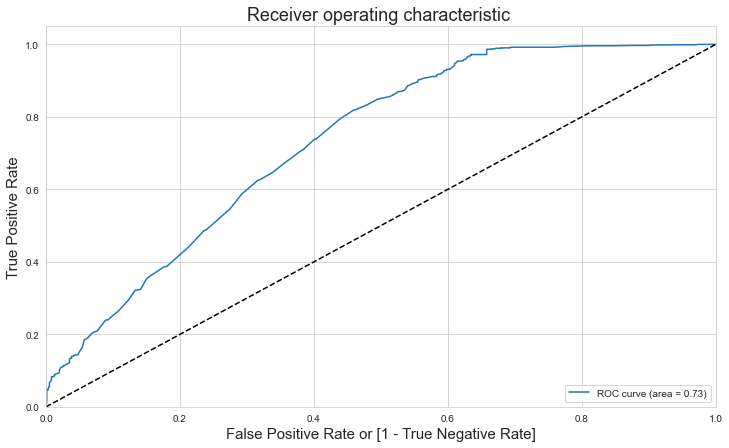

In [185]:
draw_roc(y_train_pred_final.Claim_Submitted, y_train_pred_final.Claim_submission_Probability)

Finding Optimal Cutoff:

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [186]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Claim_submission_Probability.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head(20)

,Claim_Submitted,Claim_submission_Probability,ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.672248,129,1,1,1,1,1,1,1,1,0,0,0
1,1,0.607851,2241,1,1,1,1,1,1,1,1,0,0,0
2,0,0.612428,321,1,1,1,1,1,1,1,1,0,0,0
3,1,0.594009,5152,1,1,1,1,1,1,1,0,0,0,0
4,0,0.616985,3981,1,1,1,1,1,1,1,1,0,0,0
5,1,0.584696,11604,1,1,1,1,1,1,1,0,0,0,0
6,0,0.580016,4847,1,1,1,1,1,1,1,0,0,0,0
7,1,0.871726,6804,1,1,1,1,1,1,1,1,1,1,0
8,0,0.612428,4425,1,1,1,1,1,1,1,1,0,0,0
9,0,0.589360,11460,1,1,1,1,1,1,1,0,0,0,0


In [187]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
#from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Claim_Submitted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi  speci
0.0   0.0  0.508841  1.000000  0.000
0.1   0.1  0.661591  0.989382  0.322
0.2   0.2  0.662083  0.989382  0.323
0.3   0.3  0.666994  0.987452  0.335
0.4   0.4  0.673379  0.971042  0.365
0.5   0.5  0.670432  0.915058  0.417
0.6   0.6  0.646857  0.589768  0.706
0.7   0.7  0.529470  0.093629  0.981
0.8   0.8  0.525540  0.075290  0.992
0.9   0.9  0.512770  0.043436  0.999


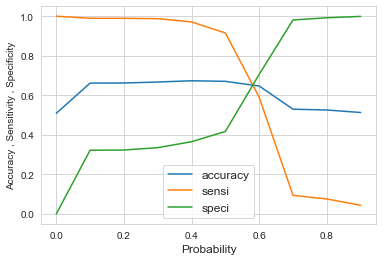

In [188]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.xlabel("Probability",size = 12)
plt.xticks(size = 10)
plt.ylabel("Accuracy , Sensitivity , Specificity",size = 10)
plt.yticks(size = 10)
plt.legend(fontsize = 12)
plt.show()

From the Graph above we can see that 0.55 seems to be the optimal cutoff probability for the Baseline.

In [189]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Claim_submission_Probability.map( lambda x: 1 if x > 0.55 else 0)

y_train_pred_final.head()

,Claim_Submitted,Claim_submission_Probability,ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.672248,129,1,1,1,1,1,1,1,1,0,0,0,1
1,1,0.607851,2241,1,1,1,1,1,1,1,1,0,0,0,1
2,0,0.612428,321,1,1,1,1,1,1,1,1,0,0,0,1
3,1,0.594009,5152,1,1,1,1,1,1,1,0,0,0,0,1
4,0,0.616985,3981,1,1,1,1,1,1,1,1,0,0,0,1


In [190]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Claim_Submitted, y_train_pred_final.final_predicted)

0.6758349705304518

Changing the Cutoff metrics to optimal value i.e 0.4 , does improve the Overall Metrics of the Model slightly to ~ 88.33 %

In [191]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Claim_Submitted, y_train_pred_final.final_predicted )
confusion2

array([[490, 510],
       [150, 886]], dtype=int64)

In [192]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [193]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8552123552123552

In [194]:
# Let us calculate specificity
TN / float(TN+FP)

0.49

In [195]:
# Calculate false postive rate - predicting Claim Submitted when the Customer does not Submit
print(FP/ float(TN+FP))

0.51


In [196]:
# Positive predictive value 
print (TP / float(TP+FP))

0.6346704871060171


In [197]:
# Negative predictive value
print (TN / float(TN+ FN))

0.765625


In [198]:
# Recall: Recall is the same as the true positive rate (TPR) or the sensitivity. 
print(f'Recall:{TP / float(TP+FN)} ')

# Precision : TP/TP+FP
TP/float(TP+FP)
print(f'Precision: {TP/float(TP+FP)}')

Recall:0.8552123552123552 
Precision: 0.6346704871060171


In [199]:
f1_score = TP/(TP + 0.5*(FP+FN))
print(f1_score)

0.7286184210526315


In [200]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_pred_final.Claim_Submitted, y_train_pred_final.final_predicted)

0.6346704871060171

In [201]:
recall_score(y_train_pred_final.Claim_Submitted, y_train_pred_final.final_predicted)

0.8552123552123552

In [202]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_train_pred_final.Claim_Submitted, y_train_pred_final.final_predicted)

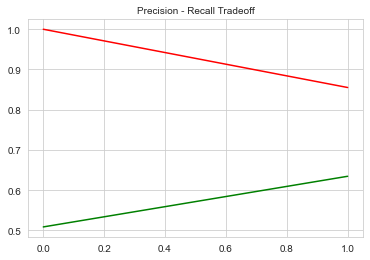

In [203]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title("Precision - Recall Tradeoff",size = 10)
plt.show()

## Making predictions on the test set

In [204]:
numerical_features

['Age', 'No_Pol']

In [205]:
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [206]:
X_test = X_test[col]
X_test.head()

,Age,No_Pol,Subject_Car_Make_Iveco,Subject_Car_Make_Volkswagen,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Muuve
5534,0.461538,0.0,0,0,0,0,0
9248,0.523077,0.2,0,0,0,0,0
11645,0.400000,0.2,0,0,0,0,0
2383,0.523077,0.0,0,0,0,0,0
11524,0.184615,0.0,0,0,0,0,0


In [207]:
X_test_sm = sm.add_constant(X_test)

In [208]:
# Making predictions on the test set
y_test_pred = res.predict(X_test_sm)

In [209]:
y_test_pred[:10]

5534     0.551663
9248     0.573234
11645    0.610399
2383     0.532560
11524    0.635002
7843     0.527767
11848    0.034924
7077     0.621522
5469     0.594009
4297     0.607851
dtype: float64

In [210]:
# reshaping y_test_pred to array:
y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred[:10]

array([0.55166273, 0.57323432, 0.61039921, 0.53256024, 0.63500195,
       0.52776744, 0.03492409, 0.62152165, 0.59400902, 0.60785095])

In [211]:
y_test_pred_final = pd.DataFrame({'Claim_Submitted':y_test.values, 'Claim_submission_Probability':y_test_pred})
y_test_pred_final['ID'] = y_test.index
y_test_pred_final.head()

,Claim_Submitted,Claim_submission_Probability,ID
0,1,0.551663,5534
1,0,0.573234,9248
2,0,0.610399,11645
3,1,0.532560,2383
4,1,0.635002,11524


In [213]:
y_test_pred_final['final_predicted'] = y_test_pred_final.Claim_submission_Probability.map(lambda x: 1 if x > 0.55 else 0)

In [214]:
y_test_pred_final.head()

,Claim_Submitted,Claim_submission_Probability,ID,final_predicted
0,1,0.551663,5534,1
1,0,0.573234,9248,1
2,0,0.610399,11645,1
3,1,0.532560,2383,0
4,1,0.635002,11524,1


In [215]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred_final.Claim_Submitted, y_test_pred_final.final_predicted)

0.7010309278350515

In [216]:
confusion2 = metrics.confusion_matrix(y_test_pred_final.Claim_Submitted, y_test_pred_final.final_predicted )
confusion2

array([[254, 200],
       [ 61, 358]], dtype=int64)

In [217]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [218]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8544152744630071

In [219]:
# Let us calculate specificity
TN / float(TN+FP)

0.5594713656387665

## Checking Model Results on Unseen Data 

In [220]:
raw_test_df = pd.read_csv('Data/Test.csv')

In [221]:
raw_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      1202 non-null   object
 1   Policy Start Date       1202 non-null   object
 2   Policy End Date         1202 non-null   object
 3   Gender                  1161 non-null   object
 4   Age                     1202 non-null   int64 
 5   First Transaction Date  1202 non-null   object
 6   No_Pol                  1202 non-null   int64 
 7   Car_Category            830 non-null    object
 8   Subject_Car_Colour      505 non-null    object
 9   Subject_Car_Make        954 non-null    object
 10  LGA_Name                546 non-null    object
 11  State                   546 non-null    object
 12  ProductName             1202 non-null   object
dtypes: int64(2), object(11)
memory usage: 122.2+ KB


In [222]:
df_null_percentage(raw_test_df)

Subject_Car_Colour        57.986689
LGA_Name                  54.575707
State                     54.575707
Car_Category              30.948419
Subject_Car_Make          20.632280
Gender                     3.410982
ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
ProductName                0.000000
dtype: float64

In [223]:
insurance_application_test_df= raw_test_df[raw_test_df.columns[raw_test_df.isnull().sum() < len(raw_test_df)/2]]

In [242]:
df_null_percentage(insurance_application_test_df)

ID                        0.0
Policy Start Date         0.0
Policy End Date           0.0
Gender                    0.0
Age                       0.0
First Transaction Date    0.0
No_Pol                    0.0
Car_Category              0.0
Subject_Car_Make          0.0
ProductName               0.0
dtype: float64

In [229]:
insurance_application_test_df.Age = insurance_application_test_df.Age.map(lambda x: valid_age(x))


In [234]:
for column in numerical_features:

    insurance_application_test_df[column].fillna(round(insurance_application_test_df[column].mean()), inplace=True)

In [236]:
insurance_application_test_df.Gender= insurance_application_test_df.Gender.map(lambda x: gender_map(x))

In [241]:
insurance_application_test_df['Subject_Car_Make'].fillna(insurance_application_test_df['Subject_Car_Make'].mode()[0],inplace = True)
insurance_application_test_df['Car_Category'].fillna(insurance_application_test_df['Car_Category'].mode()[0],inplace = True)

In [245]:
# Dummies and Scaling
dummy = pd.get_dummies(insurance_application_test_df[categorical_columns], drop_first = True)

In [246]:
insurance_application_test_df = pd.concat([insurance_application_test_df, dummy], axis=1)

In [248]:
# Dropping redundant columns
insurance_application_test_df.drop(categorical_columns, 1, inplace = True)

In [250]:
# Dropping  Date columns and assigning the dataframe to X_test
insurance_application_test_df.drop(date_cols,1,inplace = True)

In [254]:
X_test_unseen = insurance_application_test_df

In [255]:
X_test_unseen[numerical_features]= scaler.transform(X_test_unseen[numerical_features])


In [257]:
X_test_unseen = X_test_unseen[col]
X_test_unseen.head()

,Age,No_Pol,Subject_Car_Make_Iveco,Subject_Car_Make_Volkswagen,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Muuve
0,0.430769,0.0,0,0,0,0,0
1,0.215385,0.0,0,0,0,0,0
2,0.415385,0.2,0,0,0,0,0
3,0.615385,0.0,0,0,1,0,0
4,0.384615,0.0,0,0,0,0,0


In [258]:
X_test_us_sm = sm.add_constant(X_test_unseen)

In [259]:
# Making predictions on the test set
y_test_us_pred = res.predict(X_test_us_sm)

In [260]:
y_test_us_pred[:10]

0    0.561161
1    0.626037
2    0.605814
3    0.024956
4    0.575322
5    0.516035
6    0.575322
7    0.612428
8    0.669885
9    0.674602
dtype: float64

In [261]:
# reshaping y_test_pred to array:
y_test_us_pred = y_test_us_pred.values.reshape(-1)
y_test_us_pred[:10]

array([0.56116066, 0.62603715, 0.60581377, 0.02495584, 0.57532185,
       0.51603521, 0.57532185, 0.61242785, 0.66988548, 0.67460178])

In [262]:
y_test_us_pred_final = pd.DataFrame({ 'Claim_submission_Probability':y_test_us_pred})
y_test_us_pred_final['ID'] = insurance_application_test_df.ID
y_test_us_pred_final.head()

,Claim_submission_Probability,ID
0,0.561161,ID_01QM0NU
1,0.626037,ID_024NJLZ
2,0.605814,ID_02NOVWQ
3,0.024956,ID_02VSP68
4,0.575322,ID_02YB37K


In [263]:
y_test_us_pred_final['final_predicted'] = y_test_us_pred_final.Claim_submission_Probability.map(lambda x: 1 if x > 0.55 else 0)

In [264]:
y_test_us_pred_final

,Claim_submission_Probability,ID,final_predicted
0,0.561161,ID_01QM0NU,1
1,0.626037,ID_024NJLZ,1
2,0.605814,ID_02NOVWQ,1
3,0.024956,ID_02VSP68,0
4,0.575322,ID_02YB37K,1
...,...,...,...
1197,0.501610,ID_ZTTHC5X,0
1198,0.575322,ID_ZUJAFUP,1
1199,0.860578,ID_ZWHCTUM,1
1200,0.610399,ID_ZWQRL8L,1


In [265]:
submission_1 = y_test_us_pred_final[['ID','final_predicted']]

In [268]:
submission_1.columns = ['ID','target']

In [269]:
submission_1.head()

,ID,target
0,ID_01QM0NU,1
1,ID_024NJLZ,1
2,ID_02NOVWQ,1
3,ID_02VSP68,0
4,ID_02YB37K,1


In [271]:
submission_1.to_csv('Submission/submission_1.csv',index = False)